This notebook is derived from 04_DE_by_plasmid.ipynb. The purpose is to generate plots with dual guides side by side in a single panel.

In [42]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
}))
options(timeout = 100)
source("helper_functions_for_diffex.r")


# Definitions etc

In [43]:
set.seed(1234)
options(digits = 2)
stats <- c()


In [44]:
options(future.globals.maxSize = 150 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)


In [45]:
if (!exists("papermill_run")) {
    prj_name <- "Screen1"
    data_subdir_suffixes <- "L1,L2,L3,L4"
    secondary_a_path <- "S1/analysis/secondary/"
    save_seurat_h5 <- "YES"
}


In [46]:
custom_theme <- theme(
  plot.title = element_text(size = 16, hjust = 0.5),
  legend.key.size = unit(0.7, "cm"),
  legend.text = element_text(size = 14)
)


### Load Seurat file

In [47]:
df_guide <- read.table(
    "primary/S1_resources/66CRISPRi_ref_for_diffex.txt",
    sep = "\t", header = T, strip.white = T
)
integrated_h5_path <-
    "S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
neighbors_file <-
    "primary/S1_resources/neighbors_list.rds"

sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label,diffexed_gene
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE,CCNB1
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE,
rs881858,DE9-1a,DE9-1b,DE9,ckd_de,targeting,rs881858,CKD DE,
rs6839100,DE12-2a,DE12-2b,DE12,ckd_de,targeting,rs6839100,CKD DE,
rs4720089,DE14-1a,DE14-1b,DE14,ckd_de,targeting,rs4720089,CKD DE,
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE,PLIN3


In [48]:
seurat_combined <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
seurat_combined <- subset(seurat_combined, subset = status == "singlet")


Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [49]:
seurat_rna <- CreateSeuratObject(seurat_combined[["RNA"]])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data


### Load THRESHOLDS.tsv

In [50]:
thr_f_name <- paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds <- read.table(thr_f_name, header = T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)


## FeaturePlot singlet & doublet

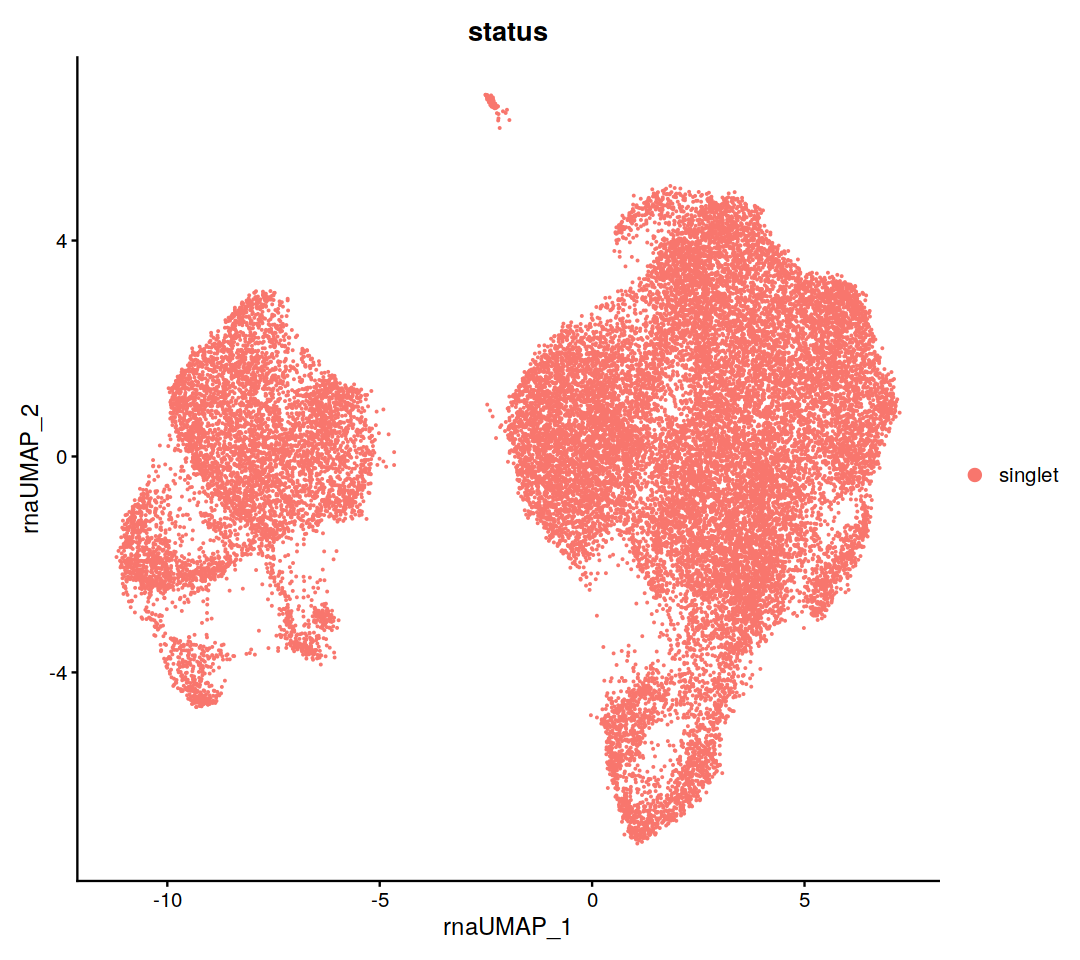

In [51]:
options(repr.plot.width = 9, repr.plot.height = 8)
DimPlot(seurat_combined, group.by = "status")


# Differential expression

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [52]:
libraries <- unique(seurat_combined$library)
seurat_libs <- list()
for (i in seq_along(libraries)) {
    lib <- libraries[i]
    seurat_libs[[i]] <- subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries


In [53]:
perturbed_cells_by_guide <-
    get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds)
length(perturbed_cells_by_guide[[3]])


[1] 796

In [54]:
df_thresholds$guide[grepl("NT", df_thresholds$guide)]


[1] "NTCE1-1a" "NTCE1-1b" "NTCE2-1a" "NTCE2-1b" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a"
[8] "NTCE4-1b"

In [55]:
# This function is not necessary. Using mark_target_pos_neg()
# Mark cells that are positive for given guides as target_positive, all others as target_negative
mark_plasmid_pos_neg <- function(
    seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
    all_cells <- Cells(seurat_obj)
    perturbed_cells <- c()
    dummy_perturbed <- c()

    for (guide in guides) {
        dummy_perturbed <- unlist(perturbed_cells_by_guide[[guide]])
        perturbed_cells <- union(perturbed_cells, dummy_perturbed)
        # cat(guide," ", length(perturbed_cells), "\n")
    }

    unperturbed_cells <- unlist(setdiff(all_cells, perturbed_cells))
    Idents(seurat_obj) <- "plasmid_negative"
    seurat_obj <- SetIdent(
        seurat_obj,
        cells = perturbed_cells,
        value = "plasmid_positive"
    )

    if (print_counts) {
        n_gplus <- length(perturbed_cells)
        n_gminus <- length(unperturbed_cells)
        cat(blue("Plasmid+ =", n_gplus, "; Plasmid- =", n_gminus, "\n"))
    }

    seurat_obj
}


### Applications

Find all unperturbed cells: these are the cells with either no guides or only NT guides

In [56]:
select_targeting_guides <- df_guide$class == "targeting"
df_targeting <- df_guide[select_targeting_guides, ]
targeting_guides <- c(df_targeting$guide1, df_targeting$guide2)
seurat_rna <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, targeting_guides)
unperturbed_cells <- Cells(subset(seurat_rna, idents = "target_negative"))


CD13-1a   867 
CD55-1a   1605 
CD73-1a   2288 
FUBP1-1a   2887 
C15orf40-1a   3553 
MAFF-1a   4036 
FTH1-1a   4473 
FTH1-2a   6504 
PLIN3-1a   7037 
PLIN3-2a   7440 
TKT-1a   7792 
TKT-2a   8264 
LGALS3-1a   8732 
LGALS3-2a   9132 
CSTB-1a   9608 
CSTB-2a   10018 
CTSB-1a   10457 
CTSB-2a   10820 
KLF6-1a   11173 
KLF6-2a   11531 
DE1-1a   11841 
DE1-2a   12173 
DE2-1a   12173 
DE2-2a   12523 
DE3-1a   12859 
DE3-2a   13168 
DE4-1a   13673 
DE4-2a   13893 
DE5-1a   14181 
DE5-2a   14482 
DE6-1a   14719 
DE6-2a   15245 
DE7-1a   15506 
DE7-2a   15706 
DE8-1a   15949 
DE8-2a   16193 
DE9-1a   16417 
DE9-2a   16417 
DE10-1a   16561 
DE10-2a   16757 
DE11-1a   16966 
DE11-2a   17139 
DE12-1a   17296 
DE12-2a   17443 
DE13-1a   17613 
DE13-2a   17745 
DE14-1a   17900 
DE14-2a   18062 
DE15-1a   18221 
DE15-2a   18388 
DE16-1a   18528 
DE16-2a   18528 
DE17-1a   18651 
DE17-2a   18774 
CD13-1b   18789 
CD55-1b   18801 
CD73-1b   18811 
FUBP1-1b   18823 
C15orf40-1b   18840 
MAFF-1b   18848 


# <font color='yellow'> DE for all Targeting Guide pairs </font> 

Load the neighbors of the targets first

In [57]:
library("rlist")
neighbors_list <- list.load(neighbors_file)


In [58]:
(df_targeting)


,gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label,diffexed_gene
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting,ANPEP,Control TSS,ANPEP
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting,CD55,Control TSS,CD55
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting,NT5E,Control TSS,NT5E
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting,FUBP1,Control TSS,FUBP1
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting,C15orf40,Control TSS,C15orf40
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting,MAFF,Control TSS,MAFF
7,Enh-23-8-FTH1,FTH1-1a,FTH1-1b,FTH1,de_control,targeting,FTH1,Control DE,FTH1
8,Enh-23-8-FTH1,FTH1-2a,FTH1-2b,FTH1,de_control,targeting,FTH1,Control DE,FTH1
9,Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE,PLIN3


In [59]:
count_idents <- function(seurat_obj, idents) {
    length(Cells(subset(seurat_obj, idents = idents)))
}


In [60]:
source("helper_functions_for_diffex.r")
df_targeting <- filter(df_guide, class == "targeting")
# df_targeting = filter(df_guide, subclass=='de_control')
# df_targeting = filter(df_guide, gene=='HIST1H4H')
df_neighbor_de <- NULL
test_use <- "LR" # "MAST" #"wilcox"
genes_to_skip <- c("DE5", "CD55", "CSTB")
genes_to_skip <- c()
lfc_threshold <- 0.10
n_tests <- 0
pos_label <- "target_positive"
neg_label <- "target_negative"

for (i in 1:nrow(df_targeting)) {
    target <- df_targeting[i, "alias"]
    target_subclass <- df_targeting[i, "subclass"]
    gene_or_rsid <- df_targeting[i, "gene_or_rsid"]

    if (target %in% genes_to_skip) {
        cat(red("Skipping", target, "\n"))
        next
    }

    cat(blue(target, ": "))
    stopifnot(gene_or_rsid %in% names(neighbors_list))

    neighbors <- neighbors_list[[gene_or_rsid]]
    n_tests <- n_tests + length(neighbors)
    guides_on_plasmid <-
        unlist(as.list(t(df_targeting[i, c("guide1", "guide2")])))
    cat(paste(guides_on_plasmid, collapse = ","), "\n")
    seurat_dummy <- mark_target_pos_neg(
        seurat_rna,
        perturbed_cells_by_guide,
        guides_on_plasmid,
        print_counts = T,
        pos_label = pos_label,
        neg_label = neg_label
    )

    if (pos_label %in% levels((Idents(seurat_dummy)))) {
        markers <- FindMarkers(
            object = seurat_dummy,
            features = neighbors,
            slot = "data",
            ident.1 = pos_label,
            ident.2 = neg_label,
            test.use = test_use,
            logfc.threshold = lfc_threshold,
            latent.vars = c("library"),
            only.pos = FALSE,
            verbose = TRUE
        )
        print("FM complete")
        flush.console()
        # latent.vars = c("library", "donor"),
        # latent.vars = c('library')
        if (nrow(markers) == 0) {
            cat(red("No DE genes", target, "\n"))
            flush.console()
            next
        }
        markers$de_gene <- rownames(markers)
        markers$target <- target
        markers$subclass <- target_subclass
        markers$plasmid <- gsub("a", "", guides_on_plasmid[[1]])
        markers$label <- df_targeting[i, "label"]
        rownames(markers) <- NULL
        df_neighbor_de <- rbind(df_neighbor_de, markers)
    } else {
        cat(
            red("No cells found:"),
            paste(guides_on_plasmid, collapse = ","),
            "\n"
        )
    }
    flush.console()
}


ANPEP : CD13-1a,CD13-1b 
CD13-1a   867 
CD13-1b   1161 
Guide+ = 1161 ; Guide- = 25981 
[1] "FM complete"
CD55 : CD55-1a,CD55-1b 
CD55-1a   796 
CD55-1b   1081 
Guide+ = 1081 ; Guide- = 26061 
[1] "FM complete"
NT5E : CD73-1a,CD73-1b 
CD73-1a   757 
CD73-1b   1020 
Guide+ = 1020 ; Guide- = 26122 
[1] "FM complete"
FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   708 
FUBP1-1b   925 
Guide+ = 925 ; Guide- = 26217 
[1] "FM complete"
C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   822 
C15orf40-1b   1076 
Guide+ = 1076 ; Guide- = 26066 
[1] "FM complete"
MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   664 
MAFF-1b   869 
Guide+ = 869 ; Guide- = 26273 
[1] "FM complete"
FTH1 : FTH1-1a,FTH1-1b 
FTH1-1a   625 
FTH1-1b   841 
Guide+ = 841 ; Guide- = 26301 
[1] "FM complete"
FTH1 : FTH1-2a,FTH1-2b 
FTH1-2a   2836 
FTH1-2b   2836 
Guide+ = 2836 ; Guide- = 24306 
[1] "FM complete"
PLIN3 : PLIN3-1a,PLIN3-1b 
PLIN3-1a   863 
PLIN3-1b   1114 
Guide+ = 1114 ; Guide- = 26028 
[1] "FM complete"
PLIN3 : PLIN3-2a,PLIN3-2b 
PL

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE2 
DE3 : DE3-1a,DE3-1b 
DE3-1a   959 
DE3-1b   1255 
Guide+ = 1255 ; Guide- = 25887 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE3 
DE3 : DE3-2a,DE3-2b 
DE3-2a   949 
DE3-2b   1271 
Guide+ = 1271 ; Guide- = 25871 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE3 
DE4 : DE4-1a,DE4-1b 
DE4-1a   1623 
DE4-1b   1703 
Guide+ = 1703 ; Guide- = 25439 
[1] "FM complete"
DE4 : DE4-2a,DE4-2b 
DE4-2a   774 
DE4-2b   985 
Guide+ = 985 ; Guide- = 26157 
[1] "FM complete"
DE5 : DE5-1a,DE5-1b 
DE5-1a   1003 
DE5-1b   1299 
Guide+ = 1299 ; Guide- = 25843 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE5 
DE5 : DE5-2a,DE5-2b 
DE5-2a   1053 
DE5-2b   1332 
Guide+ = 1332 ; Guide- = 25810 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE5 
DE6 : DE6-1a,DE6-1b 
DE6-1a   896 
DE6-1b   1189 
Guide+ = 1189 ; Guide- = 25953 
[1] "FM complete"
DE6 : DE6-2a,DE6-2b 
DE6-2a   1814 
DE6-2b   1825 
Guide+ = 1825 ; Guide- = 25317 
[1] "FM complete"
DE7 : DE7-1a,DE7-1b 
DE7-1a   1010 
DE7-1b   1296 
Guide+ = 1296 ; Guide- = 25846 
[1] "FM complete"
DE7 : DE7-2a,DE7-2b 
DE7-2a   832 
DE7-2b   1076 
Guide+ = 1076 ; Guide- = 26066 
[1] "FM complete"
DE8 : DE8-1a,DE8-1b 
DE8-1a   974 
DE8-1b   1340 
Guide+ = 1340 ; Guide- = 25802 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE8 
DE8 : DE8-2a,DE8-2b 
DE8-2a   1124 
DE8-2b   1473 
Guide+ = 1473 ; Guide- = 25669 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE8 
DE9 : DE9-1a,DE9-1b 
DE9-1a   933 
DE9-1b   1296 
Guide+ = 1296 ; Guide- = 25846 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE9 
DE9 : DE9-2a,DE9-2b 
DE9-2a   0 
DE9-2b   0 
Guide+ = 0 ; Guide- = 27142 
No cells found: DE9-2a,DE9-2b 
DE10 : DE10-1a,DE10-1b 
DE10-1a   735 
DE10-1b   953 
Guide+ = 953 ; Guide- = 26189 
[1] "FM complete"
DE10 : DE10-2a,DE10-2b 
DE10-2a   797 
DE10-2b   1059 
Guide+ = 1059 ; Guide- = 26083 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE10 
DE11 : DE11-1a,DE11-1b 
DE11-1a   978 
DE11-1b   1220 
Guide+ = 1220 ; Guide- = 25922 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE11 
DE11 : DE11-2a,DE11-2b 
DE11-2a   858 
DE11-2b   1106 
Guide+ = 1106 ; Guide- = 26036 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE11 
DE12 : DE12-1a,DE12-1b 
DE12-1a   868 
DE12-1b   1119 
Guide+ = 1119 ; Guide- = 26023 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE12 
DE12 : DE12-2a,DE12-2b 
DE12-2a   795 
DE12-2b   1075 
Guide+ = 1075 ; Guide- = 26067 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE12 
DE13 : DE13-1a,DE13-1b 
DE13-1a   797 
DE13-1b   824 
Guide+ = 824 ; Guide- = 26318 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE13 
DE13 : DE13-2a,DE13-2b 
DE13-2a   670 
DE13-2b   885 
Guide+ = 885 ; Guide- = 26257 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE13 
DE14 : DE14-1a,DE14-1b 
DE14-1a   941 
DE14-1b   1250 
Guide+ = 1250 ; Guide- = 25892 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE14 
DE14 : DE14-2a,DE14-2b 
DE14-2a   872 
DE14-2b   1110 
Guide+ = 1110 ; Guide- = 26032 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE14 
DE15 : DE15-1a,DE15-1b 
DE15-1a   844 
DE15-1b   1078 
Guide+ = 1078 ; Guide- = 26064 
[1] "FM complete"
DE15 : DE15-2a,DE15-2b 
DE15-2a   1013 
DE15-2b   1357 
Guide+ = 1357 ; Guide- = 25785 
[1] "FM complete"
DE16 : DE16-1a,DE16-1b 
DE16-1a   741 
DE16-1b   1049 
Guide+ = 1049 ; Guide- = 26093 
[1] "FM complete"
DE16 : DE16-2a,DE16-2b 
DE16-2a   0 
DE16-2b   901 
Guide+ = 901 ; Guide- = 26241 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE16 
DE17 : DE17-1a,DE17-1b 
DE17-1a   815 
DE17-1b   1076 
Guide+ = 1076 ; Guide- = 26066 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE17 
DE17 : DE17-2a,DE17-2b 
DE17-2a   798 
DE17-2b   1080 
Guide+ = 1080 ; Guide- = 26062 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE17 


In [61]:
df_neighbor_de


p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
4.3e-151,-0.63,0.463,0.78,1.6e-146,ANPEP,ANPEP,tss,CD13-1,Control TSS
1.2e-13,-0.14,0.775,0.83,4.5e-09,IDH2,ANPEP,tss,CD13-1,Control TSS
1.4e-99,-0.21,0.088,0.37,5.0e-95,CD55,CD55,tss,CD55-1,Control TSS
5.3e-267,-0.72,0.335,0.80,1.9e-262,NT5E,NT5E,tss,CD73-1,Control TSS
6.0e-54,-0.25,0.476,0.68,2.2e-49,FUBP1,FUBP1,tss,FUBP1-1,Control TSS
1.5e-193,-0.37,0.167,0.59,5.6e-189,C15orf40,C15orf40,tss,C15orf40-1,Control TSS
4.5e-36,-0.11,0.079,0.24,1.7e-31,MAFF,MAFF,tss,MAFF-1,Control TSS
5.0e-08,-0.19,0.974,0.98,1.8e-03,LGALS1,MAFF,tss,MAFF-1,Control TSS
0.0e+00,-1.70,1.000,1.00,0.0e+00,FTH1,FTH1,de_control,FTH1-1,Control DE


### Correct p-values by total number of comparisons

In [62]:
print(n_tests)
df_neighbor_de$adjusted_p_val <- p.adjust(
    p = df_neighbor_de$p_val,
    method = "bonferroni",
    n = n_tests
)


[1] 1294


In [63]:
# df_neighbor_de %>%
#     filter(plasmid == "DE18-1") %>%
#     nrow()

# neighbors_list[["rs77924615"]]
# df_targeting %>% filter(alias == "DE20")
# # head(df_targeting)
# names(neighbors_list)


In [64]:
table(df_neighbor_de$plasmid)



C15orf40-1     CD13-1     CD55-1     CD73-1     CSTB-1     CSTB-2     CTSB-1 
         1          2          1          1          2          1          1 
    CTSB-2      DE1-1      DE1-2     DE10-1     DE15-1     DE15-2     DE16-1 
         2          1          1          1          1          1          1 
     DE4-1      DE4-2      DE6-1      DE6-2      DE7-1      DE7-2     FTH1-1 
         1          1          1          1          2          2          3 
    FTH1-2    FUBP1-1     KLF6-1     KLF6-2   LGALS3-1   LGALS3-2     MAFF-1 
         3          1          1          2          2          1          2 
   PLIN3-1    PLIN3-2      TKT-1      TKT-2 
         2          3          1          1 

In [65]:
nrow(df_targeting)


[1] 54

Write to file

In [66]:
lfc <- gsub("\\.", "_", lfc_threshold)
de_f_name <- paste0(
    secondary_a_path,
    "/integrated/DE_outputs/DE_genes_by_plasmid_LFC_",
    lfc,
    "_UNFILTERED.tsv"
)
write.table(df_neighbor_de, de_f_name, sep = "\t", quote = F, row.names = F)


Filter out spurious hits

In [72]:
# Some genes come up as differentially expressed all the time
# Filter those out, and write to another file
# No need for filtering when you're testing diffex over neighbors
funky_de_genes = c(
    "HMOX1", "AL357507.1", "IFI27", "AL138828.1",
    "SQSTM1", "PLCG2", "PLIN2", "SAA1", "RARRES2", "CDKN1A"
)
df_neighbor_de <- filter(df_neighbor_de, !(de_gene %in% funky_de_genes))

de_f_name <- paste0(
    secondary_a_path,
    "/integrated/DE_outputs/DE_genes_by_plasmid_LFC_",
    lfc,
    "_FILTERED.tsv"
)
write.table(df_neighbor_de, de_f_name, sep = "\t", quote = F, row.names = F)


# Inpect DE results

Print top high-confidence hits

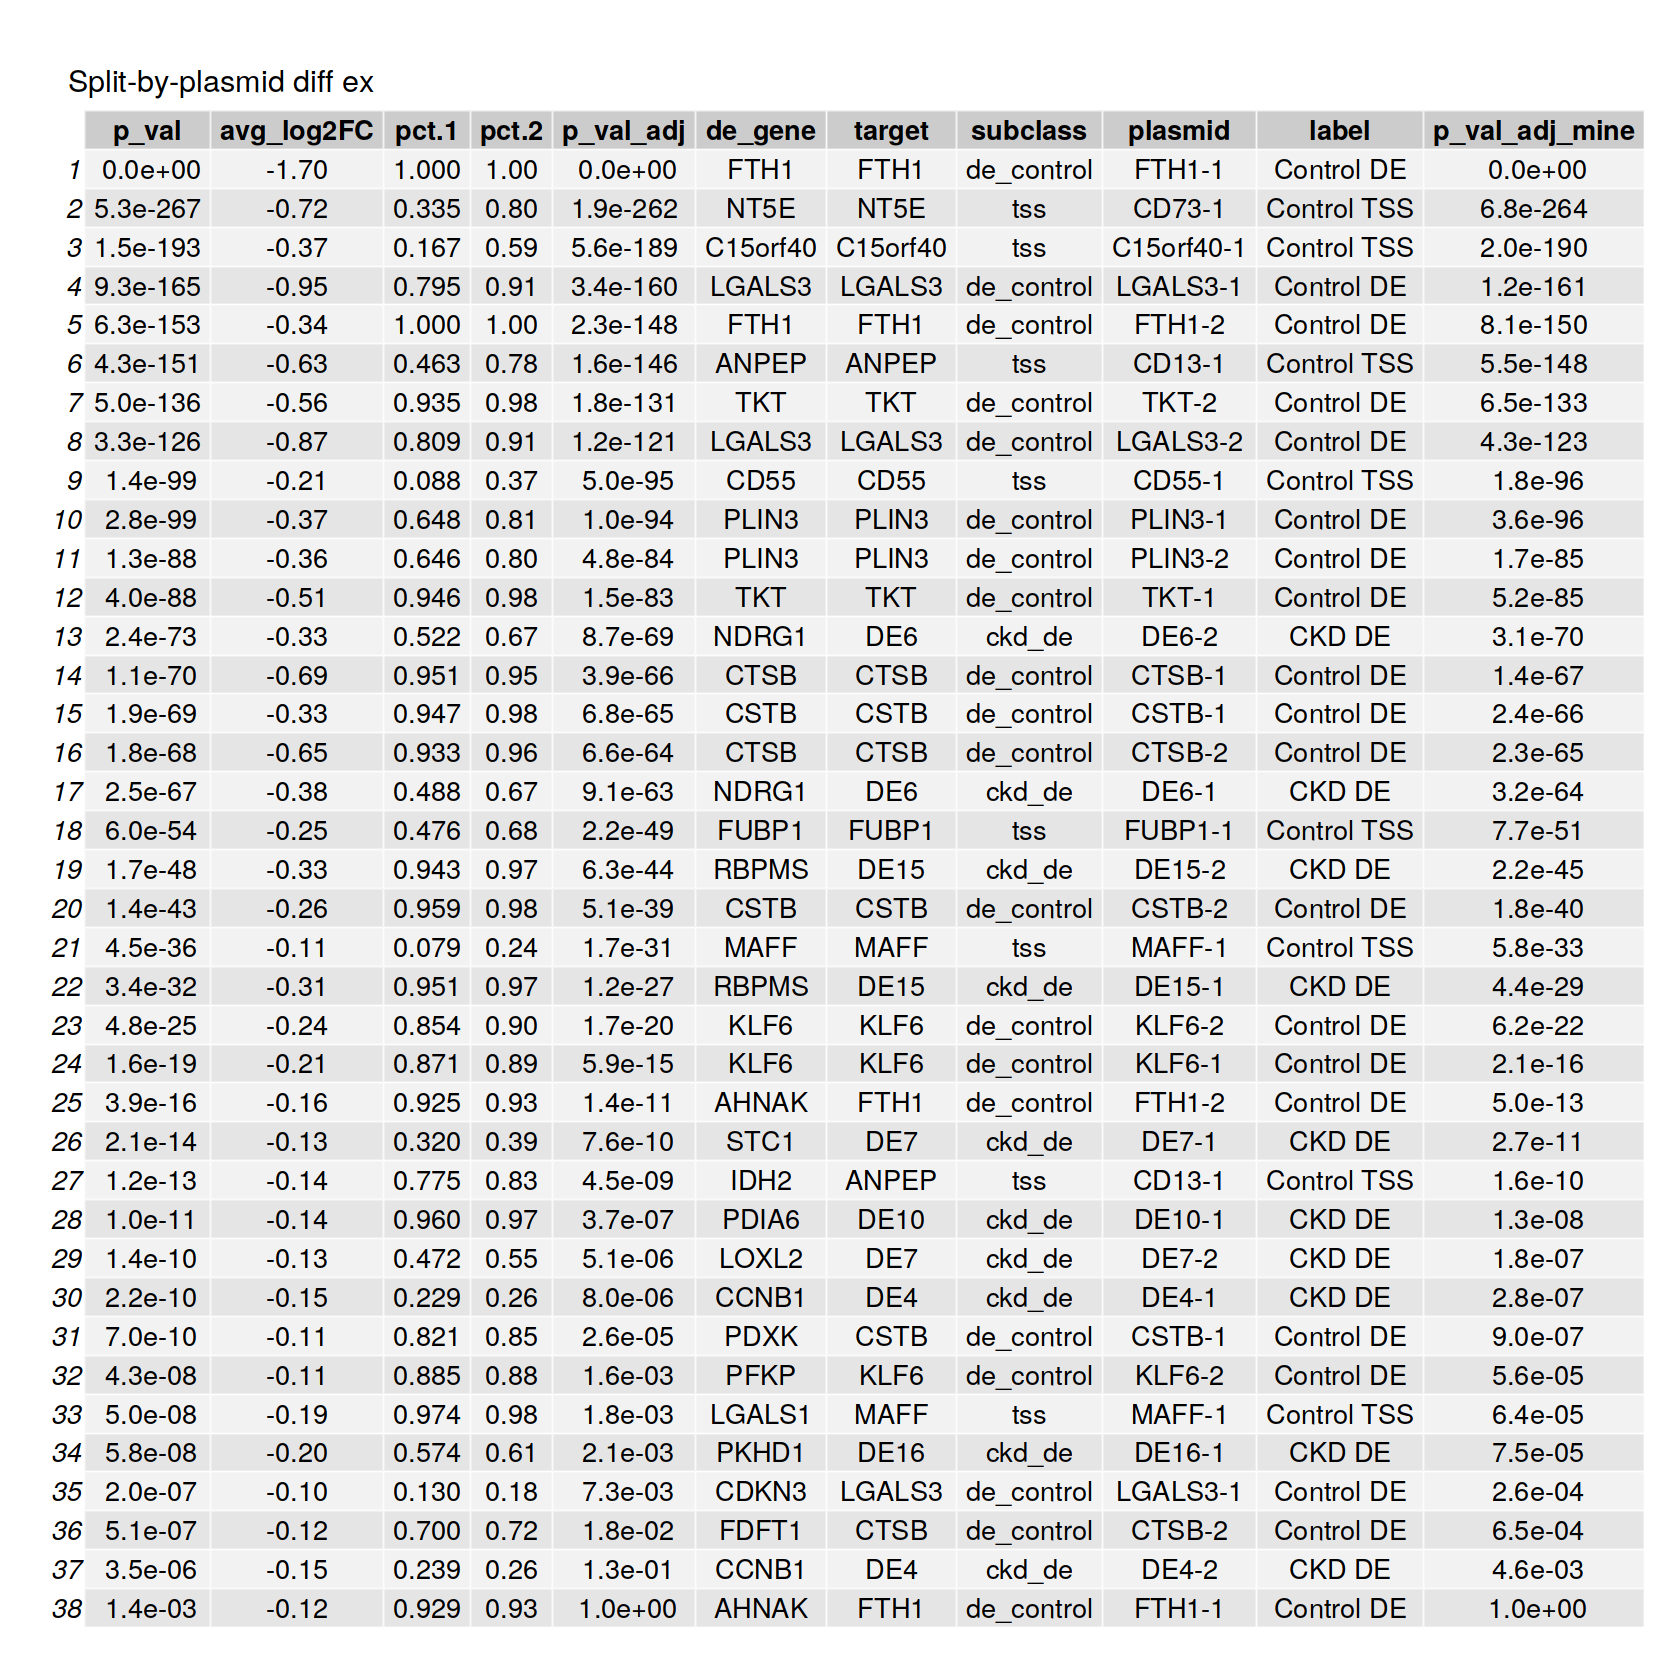

In [77]:
df_top_hits <- df_neighbor_de %>%
    filter(avg_log2FC < 0) %>%
    arrange(p_val_adj) %>%
    head(40)

tb <- ggtexttable(
    df_top_hits,
    theme = ttheme(base_size = 16)
) %>% tab_add_title(
    text = "Split-by-plasmid diff ex",
    face = "plain",
    size = 18
)
options(repr.plot.width = 14, repr.plot.height = 14)
print(tb)


In [78]:
df_neighbor_de %>% arrange(adjusted_p_val)


p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
0.0e+00,-1.70,1.000,1.00,0.0e+00,FTH1,FTH1,de_control,FTH1-1,Control DE,0.0e+00
5.3e-267,-0.72,0.335,0.80,1.9e-262,NT5E,NT5E,tss,CD73-1,Control TSS,6.8e-264
1.5e-193,-0.37,0.167,0.59,5.6e-189,C15orf40,C15orf40,tss,C15orf40-1,Control TSS,2.0e-190
9.3e-165,-0.95,0.795,0.91,3.4e-160,LGALS3,LGALS3,de_control,LGALS3-1,Control DE,1.2e-161
6.3e-153,-0.34,1.000,1.00,2.3e-148,FTH1,FTH1,de_control,FTH1-2,Control DE,8.1e-150
4.3e-151,-0.63,0.463,0.78,1.6e-146,ANPEP,ANPEP,tss,CD13-1,Control TSS,5.5e-148
5.0e-136,-0.56,0.935,0.98,1.8e-131,TKT,TKT,de_control,TKT-2,Control DE,6.5e-133
3.3e-126,-0.87,0.809,0.91,1.2e-121,LGALS3,LGALS3,de_control,LGALS3-2,Control DE,4.3e-123
1.4e-99,-0.21,0.088,0.37,5.0e-95,CD55,CD55,tss,CD55-1,Control TSS,1.8e-96


# Visualize Knockdowns

## TSS controls

ANPEP : CD13-1a,CD13-1b 
CD13-1a   867 
CD13-1b   1161 
Guide+ = 1161 ; Guide- = 25981 
CD55 : CD55-1a,CD55-1b 
CD55-1a   796 
CD55-1b   1081 
Guide+ = 1081 ; Guide- = 26061 
NT5E : CD73-1a,CD73-1b 
CD73-1a   757 
CD73-1b   1020 
Guide+ = 1020 ; Guide- = 26122 
FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   708 
FUBP1-1b   925 
Guide+ = 925 ; Guide- = 26217 
C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   822 
C15orf40-1b   1076 
Guide+ = 1076 ; Guide- = 26066 
MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   664 
MAFF-1b   869 
Guide+ = 869 ; Guide- = 26273 


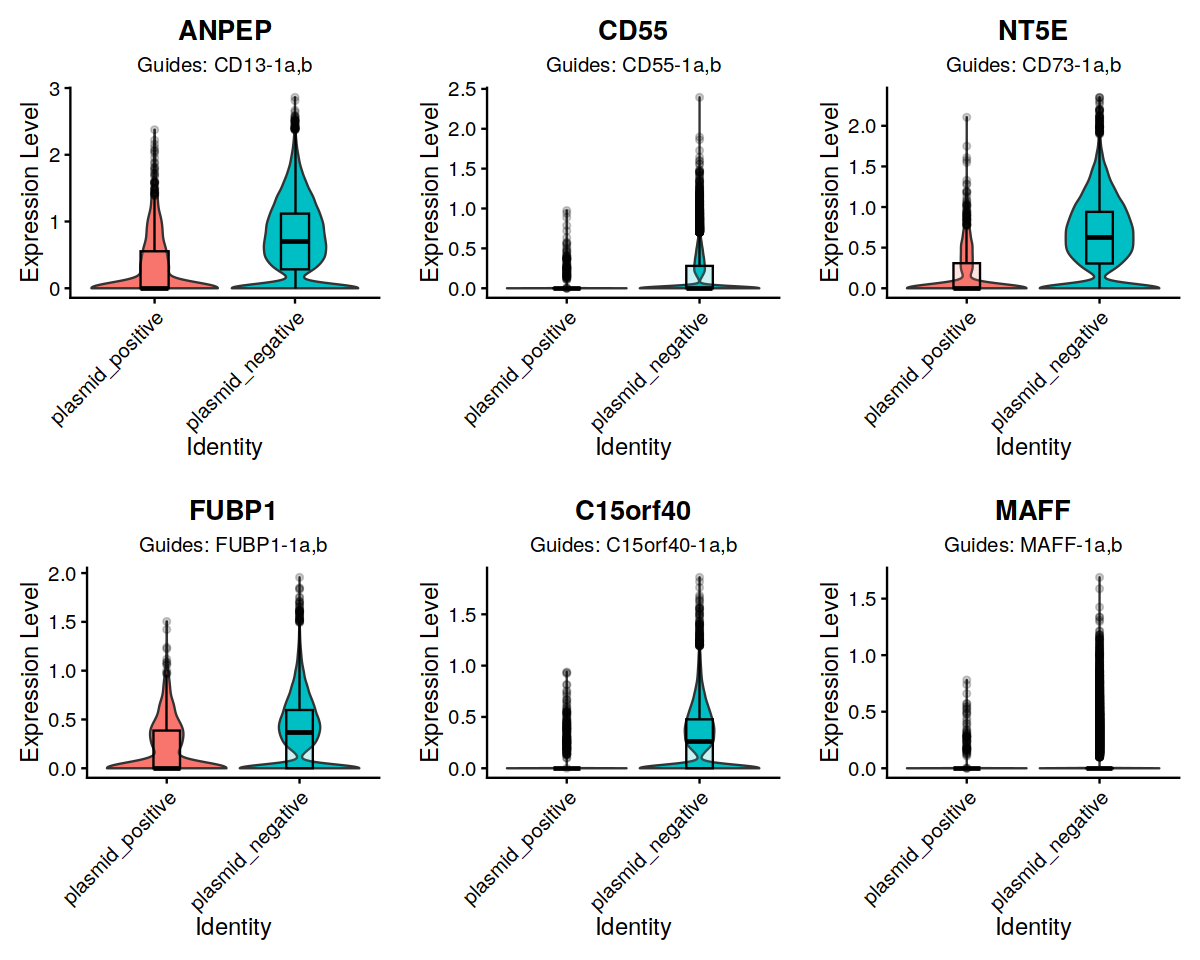

In [79]:
source("helper_functions_for_diffex.r")
df_tss <- filter(df_guide, subclass == "tss")
plots <- vlnplot_for_plasmids(seurat_rna, df_tss, perturbed_cells_by_guide)
options(repr.plot.width = 10, repr.plot.height = 8)
ggarrange(plotlist = plots, ncol = 3, nrow = 2)


## DE controls

FTH1 : FTH1-1a,FTH1-1b 
FTH1-1a   625 
FTH1-1b   841 
Guide+ = 841 ; Guide- = 26301 
FTH1 : FTH1-2a,FTH1-2b 
FTH1-2a   2836 
FTH1-2b   2836 
Guide+ = 2836 ; Guide- = 24306 
PLIN3 : PLIN3-1a,PLIN3-1b 
PLIN3-1a   863 
PLIN3-1b   1114 
Guide+ = 1114 ; Guide- = 26028 
PLIN3 : PLIN3-2a,PLIN3-2b 
PLIN3-2a   781 
PLIN3-2b   1049 
Guide+ = 1049 ; Guide- = 26093 
TKT : TKT-1a,TKT-1b 
TKT-1a   674 
TKT-1b   901 
Guide+ = 901 ; Guide- = 26241 
TKT : TKT-2a,TKT-2b 
TKT-2a   872 
TKT-2b   1167 
Guide+ = 1167 ; Guide- = 25975 
LGALS3 : LGALS3-1a,LGALS3-1b 
LGALS3-1a   912 
LGALS3-1b   1166 
Guide+ = 1166 ; Guide- = 25976 
LGALS3 : LGALS3-2a,LGALS3-2b 
LGALS3-2a   811 
LGALS3-2b   1072 
Guide+ = 1072 ; Guide- = 26070 
CSTB : CSTB-1a,CSTB-1b 
CSTB-1a   968 
CSTB-1b   1254 
Guide+ = 1254 ; Guide- = 25888 
CSTB : CSTB-2a,CSTB-2b 
CSTB-2a   931 
CSTB-2b   1216 
Guide+ = 1216 ; Guide- = 25926 
CTSB : CTSB-1a,CTSB-1b 
CTSB-1a   998 
CTSB-1b   1249 
Guide+ = 1249 ; Guide- = 25893 
CTSB : CTSB-2a,CTSB-2b 
CT

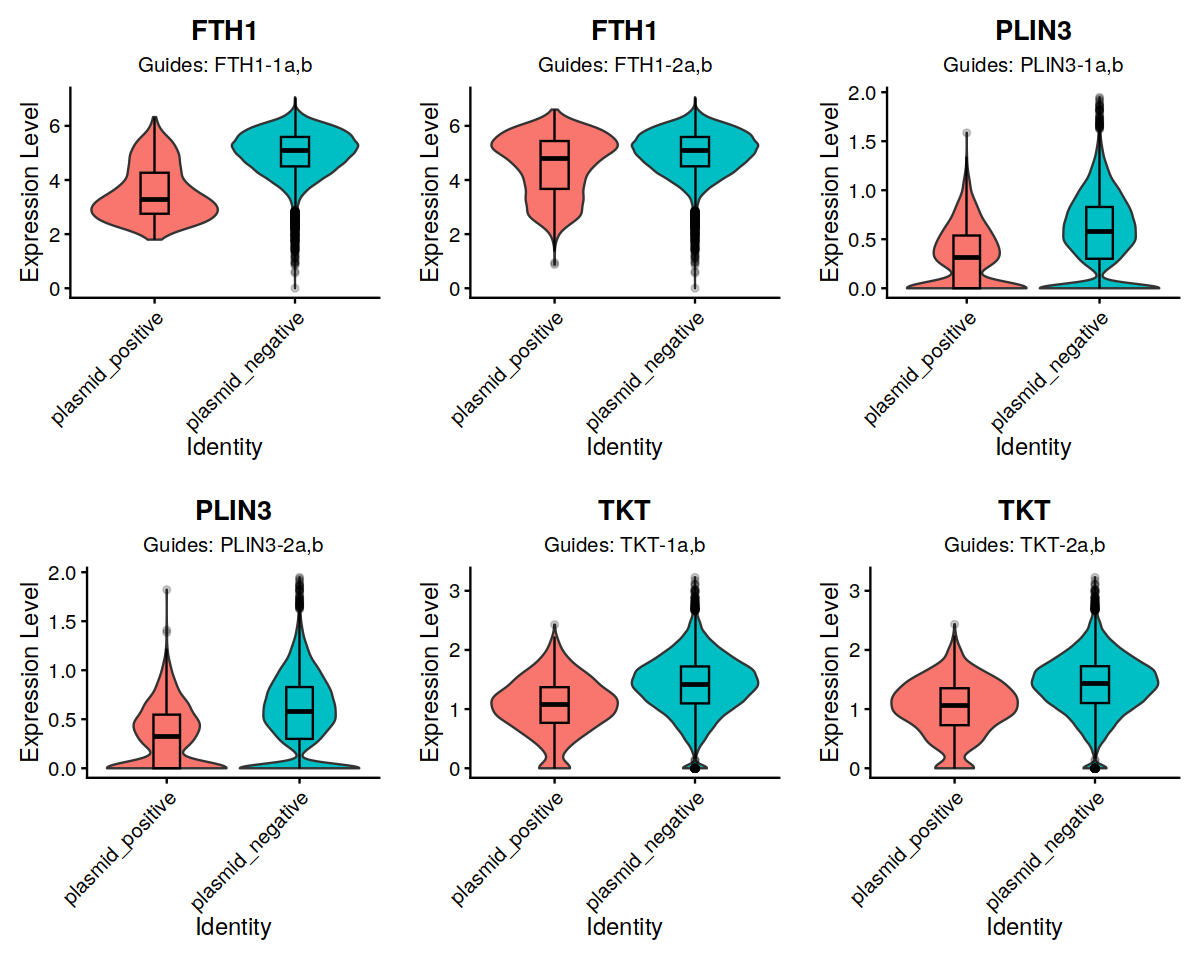

$`1`

$`2`

$`3`

attr(,"class")
[1] "list"      "ggarrange"

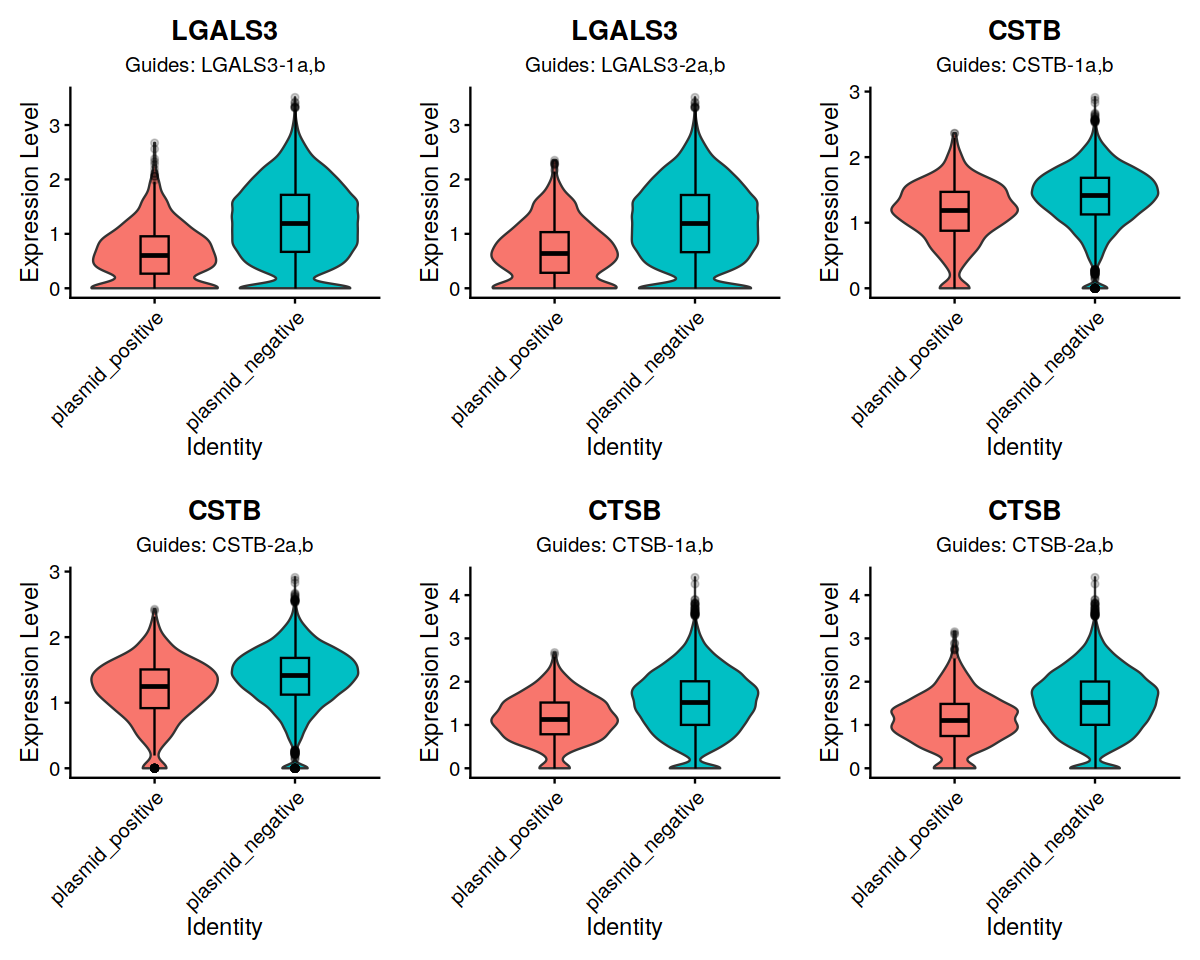

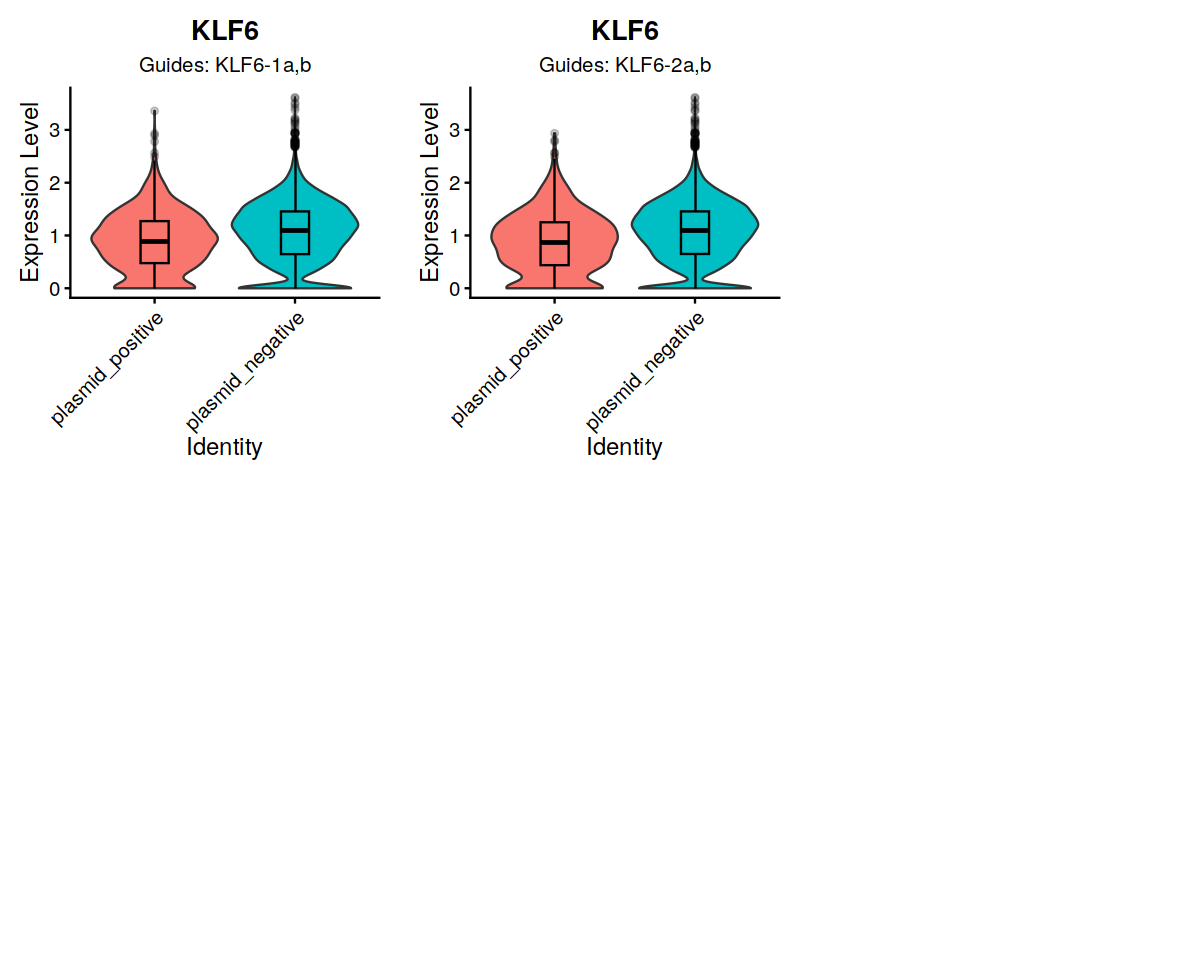

In [80]:
df_neighbor_de_control <- filter(df_guide, subclass == "de_control")
plots <- vlnplot_for_plasmids(
    seurat_rna,
    df_neighbor_de_control,
    perturbed_cells_by_guide
)
options(repr.plot.width = 10, repr.plot.height = 8)
ggarrange(plotlist = plots, ncol = 3, nrow = 2)


## CKD DE 

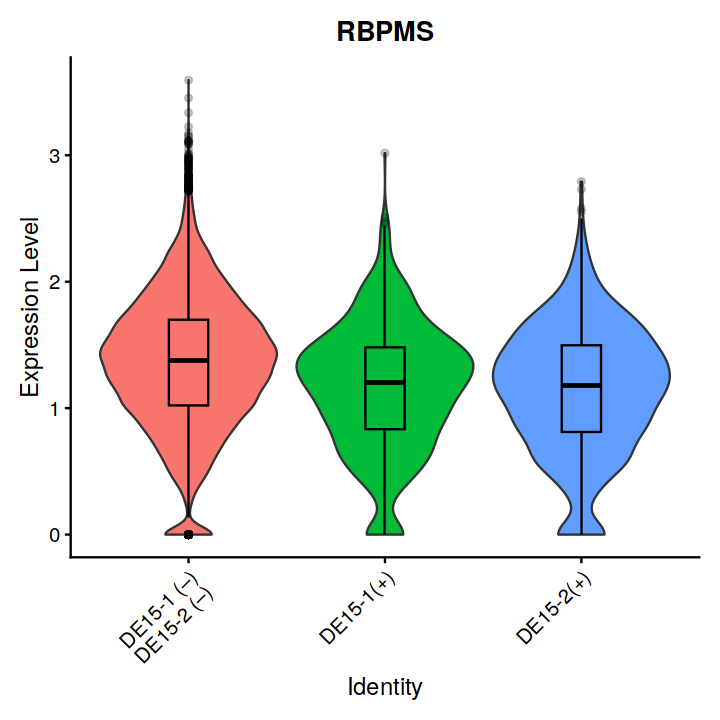

In [81]:
# plasmid_1  = c("DE6-1a", "DE6-1b")
# plasmid_2  = c("DE6-2a", "DE6-2b")
# plasmid_labels = c("DE6-1", "DE6-2")
# target_gene = "NDRG1"

plasmid_1 <- c("DE15-1a", "DE15-1b")
plasmid_2 <- c("DE15-2a", "DE15-2b")
plasmid_labels <- c("DE15-1", "DE15-2")
target_gene <- "RBPMS"

# plasmid_1  = c("FTH1-1a", "FTH1-1b")
# plasmid_2  = c("FTH1-2a", "FTH1-2b")
# plasmid_labels = c("FTH1-1", "FTH1-2")
# target_gene = 'FTH1'

plasmid_1_cells <- union(
    perturbed_cells_by_guide[[plasmid_1[[1]]]],
    perturbed_cells_by_guide[[plasmid_1[[2]]]]
)

plasmid_2_cells <- union(
    perturbed_cells_by_guide[[plasmid_2[[1]]]],
    perturbed_cells_by_guide[[plasmid_2[[2]]]]
)

common_cells <- intersect(plasmid_1_cells, plasmid_2_cells)
all_cells <- Cells(seurat_rna)
usable_cells <- setdiff(all_cells, common_cells)

seurat_dummy <- subset(seurat_rna, cells = usable_cells)

Idents(seurat_dummy) <-
    paste(plasmid_labels[1], "(\u2013)\n", plasmid_labels[2], "(\u2013)")
seurat_dummy <- SetIdent(
    seurat_dummy,
    cells = plasmid_1_cells,
    value = paste0(plasmid_labels[1], "(+)")
)
seurat_dummy <- SetIdent(
    seurat_dummy,
    cells = plasmid_2_cells,
    value = paste0(plasmid_labels[2], "(+)")
)

options(repr.plot.width = 6, repr.plot.height = 6)
plot <- VlnPlot(
    object = seurat_dummy,
    features = target_gene,
    idents = NULL,
    pt.size = 0,
    sort = T,
    ncol = 1
) +
    geom_boxplot(width = .2, color = "black", alpha = 0.2) +
    theme(legend.position = "none")

plot


In [82]:
length(unlist(perturbed_cells_by_guide["DE15-1a"]))
sum(seurat_libs[[1]][["sgRNA"]]@counts["DE15-1a", ] >= 14) +
    sum(seurat_libs[[2]][["sgRNA"]]@counts["DE15-1a", ] >= 10) +
    sum(seurat_libs[[3]][["sgRNA"]]@counts["DE15-1a", ] >= 38) +
    sum(seurat_libs[[4]][["sgRNA"]]@counts["DE15-1a", ] >= 34)
head(tail(df_thresholds, 35), 3)


[1] 844

[1] 845

,guide,Lib_1,Lib_2,Lib_3,Lib_4
,<chr>,<int>,<int>,<int>,<int>
98,DE15-1b,9,7,19,13
99,DE15-2a,13,9,21,15
100,DE15-2b,17,18,65,43


# Volcano Plot v1

In [83]:
colors <- ifelse(
    df_neighbor_de$subclass == "tss", "black",
    ifelse(df_neighbor_de$subclass == "de_control", "gray", "green")
)

names(colors) <- df_neighbor_de$label
annotations <- df_neighbor_de$de_gene
plasmid_names <- gsub("-", ":", df_neighbor_de$plasmid)
annotations <- paste0(df_neighbor_de$de_gene, "[", plasmid_names, "]")
# annotations = paste0("expression(", df_neighbor_de$de_gene, "[",df_neighbor_de$plasmid,"])")
# annotations = paste0("italic('", df_neighbor_de$de_gene, "')")
# annotations =  paste0("italic('", df_neighbor_de$de_gene, "')")


Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 21 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


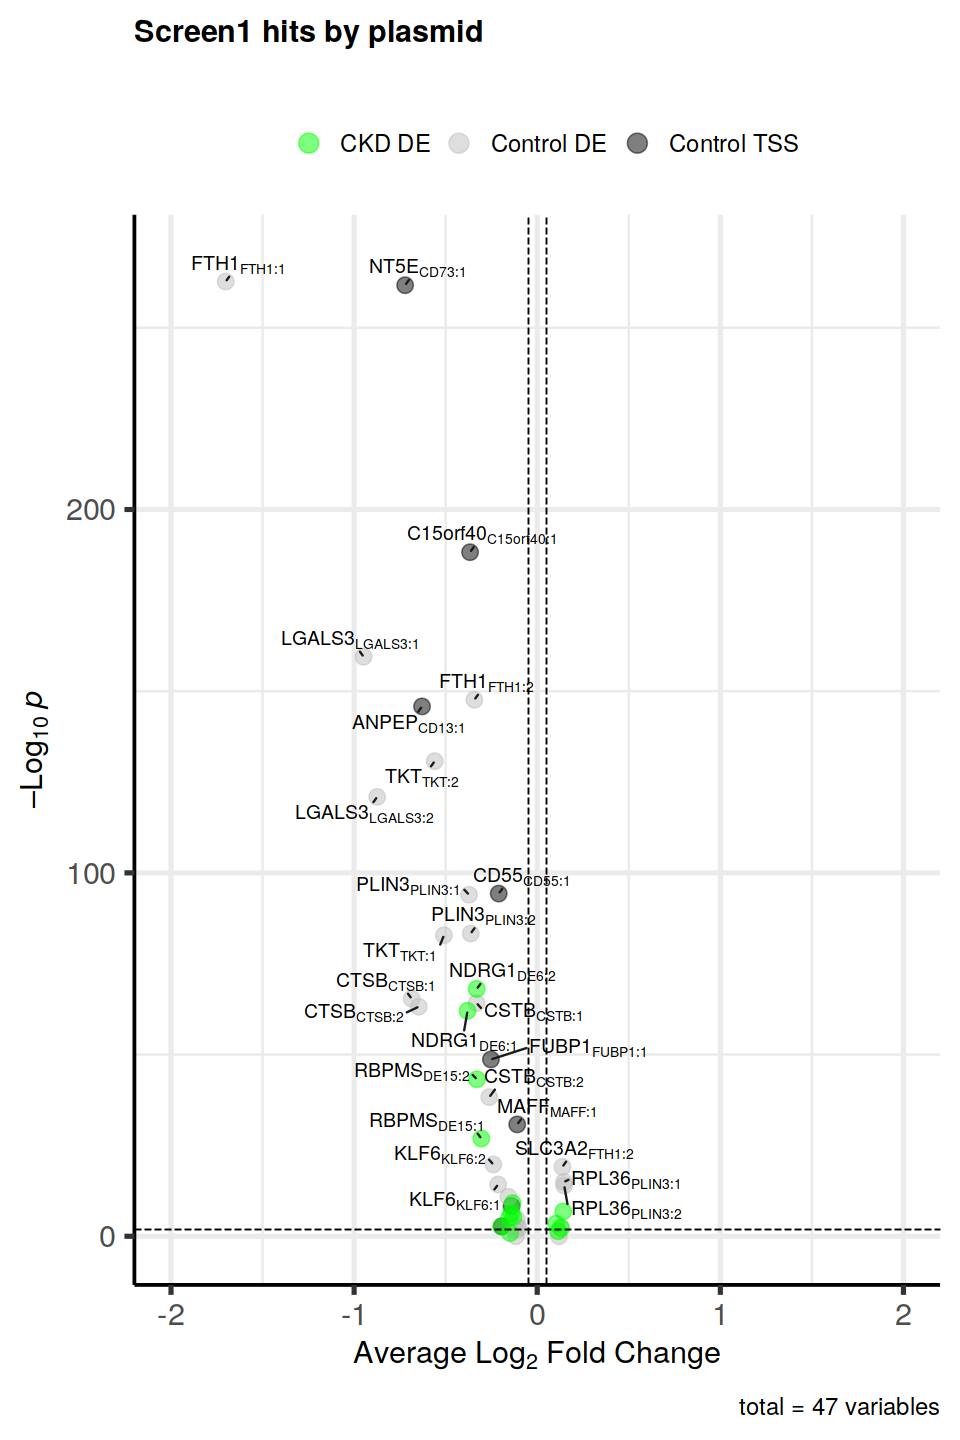

In [84]:
options(repr.plot.width = 8, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de,
    lab = annotations,
    x = "avg_log2FC",
    y = "p_val_adj",
    title = paste(prj_name, "hits by plasmid"),
    subtitle = "",
    colCustom = colors,
    drawConnectors = TRUE,
    arrowheads = FALSE,
    pCutoff = 10e-3,
    FCcutoff = 0.05,
    pointSize = 4.0,
    labSize = 4.0,
    parseLabels = T
) +
    xlim(-2, 2) +
    xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
    ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,


## Volcano Plot

In [85]:
colors <- ifelse(
    df_neighbor_de$subclass == "tss", "black",
    ifelse(df_neighbor_de$subclass == "de_control", "gray", "green")
)
names(colors) <- df_neighbor_de$label
logfc_threshold <- 0.01


Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


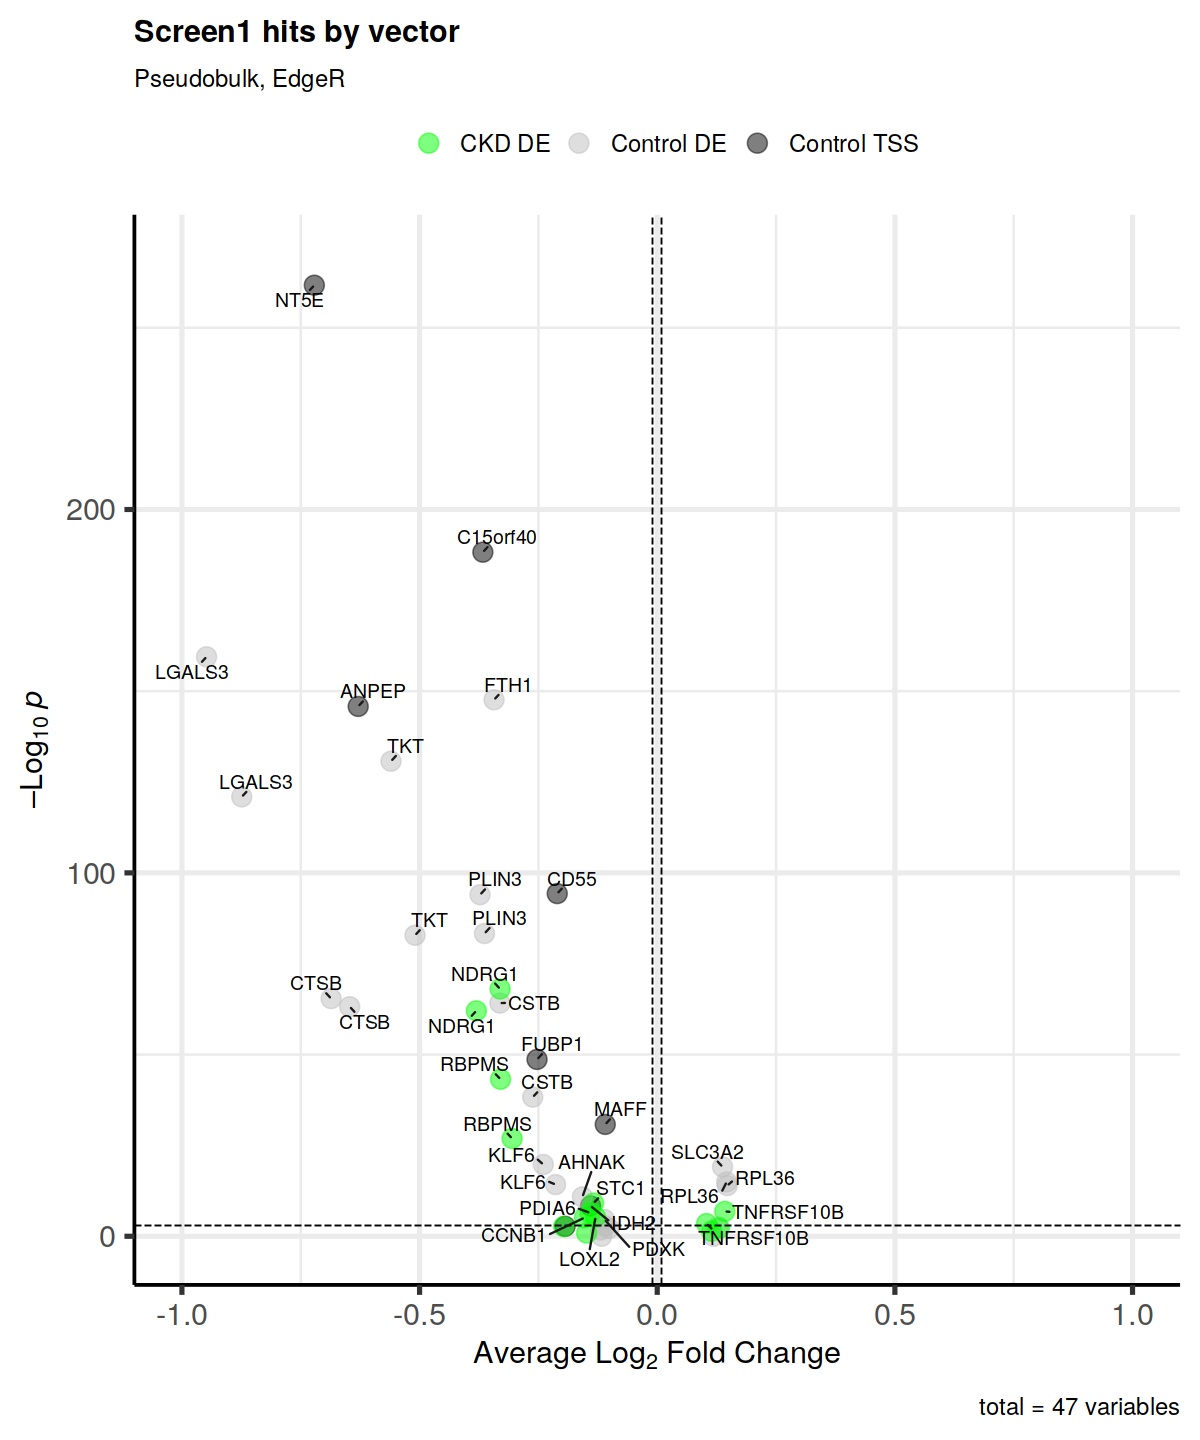

In [86]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de,
    lab = df_neighbor_de$de_gene,
    x = "avg_log2FC",
    y = "p_val_adj",
    title = paste(prj_name, "hits by vector"),
    subtitle = "Pseudobulk, EdgeR",
    colCustom = colors,
    drawConnectors = TRUE,
    arrowheads = FALSE,
    pCutoff = 10e-04,
    FCcutoff = logfc_threshold,
    pointSize = 5.0,
    labSize = 4.0
) +
    xlim(-1, 1) +
    xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
    ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,


### Plot just the control TSS

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


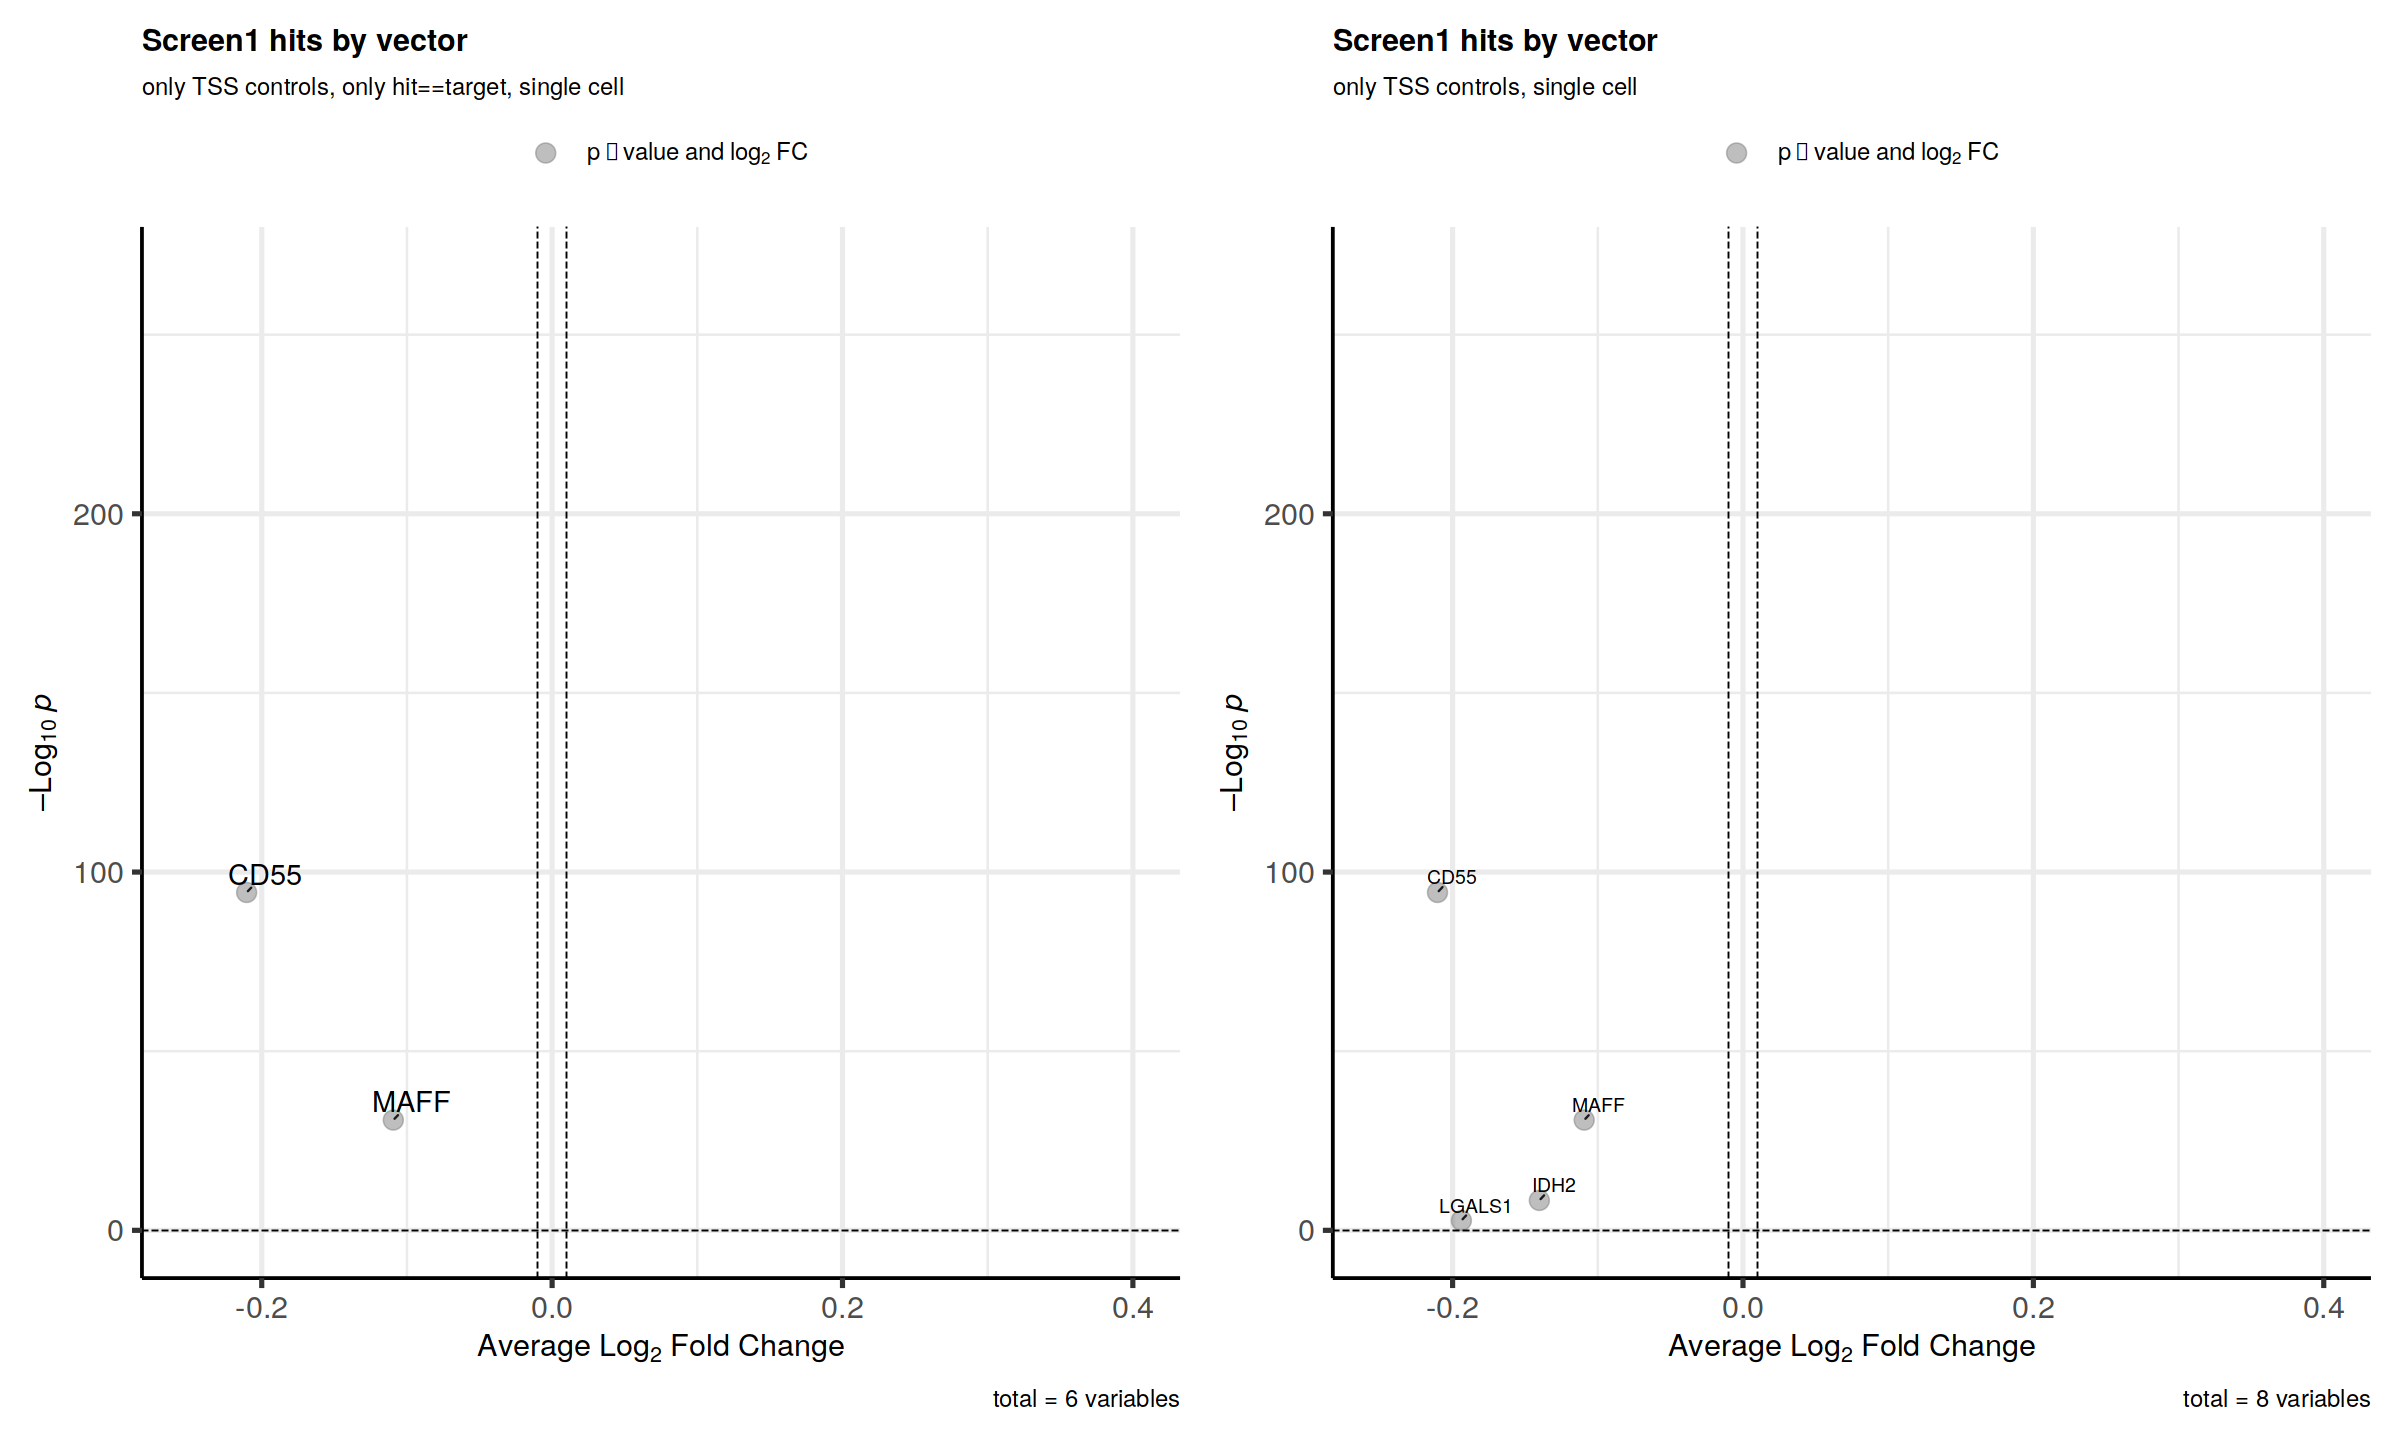

In [87]:
de_filter <- (df_neighbor_de$subclass == "tss") & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset <- df_neighbor_de[de_filter, ]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 <- EnhancedVolcano(df_neighbor_de_subset,
    lab = df_neighbor_de_subset$de_gene,
    x = "avg_log2FC",
    y = "p_val_adj",
    title = paste(prj_name, "hits by vector"),
    subtitle = "only TSS controls, only hit==target, single cell",
    col = "gray",
    drawConnectors = TRUE,
    arrowheads = FALSE,
    pCutoff = 10e-1,
    FCcutoff = logfc_threshold,
    pointSize = 5.0,
    labSize = 6.0
) +
    xlim(-0.25, .4) +
    xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
    ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter <- (df_neighbor_de$subclass == "tss")
df_neighbor_de_subset <- df_neighbor_de[de_filter, ]
p2 <- EnhancedVolcano(df_neighbor_de_subset,
    lab = df_neighbor_de_subset$de_gene,
    x = "avg_log2FC",
    y = "p_val_adj",
    title = paste(prj_name, "hits by vector"),
    subtitle = "only TSS controls, single cell",
    col = "gray",
    drawConnectors = TRUE,
    arrowheads = FALSE,
    pCutoff = 10e-1,
    FCcutoff = logfc_threshold,
    pointSize = 5.0,
    labSize = 4.0
) +
    xlim(-0.25, .4) +
    xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
    ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2


In [88]:
de_filter <-
    (df_neighbor_de$subclass == "tss") &
        (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset <- df_neighbor_de[de_filter, ]


### Plot just the control DE

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


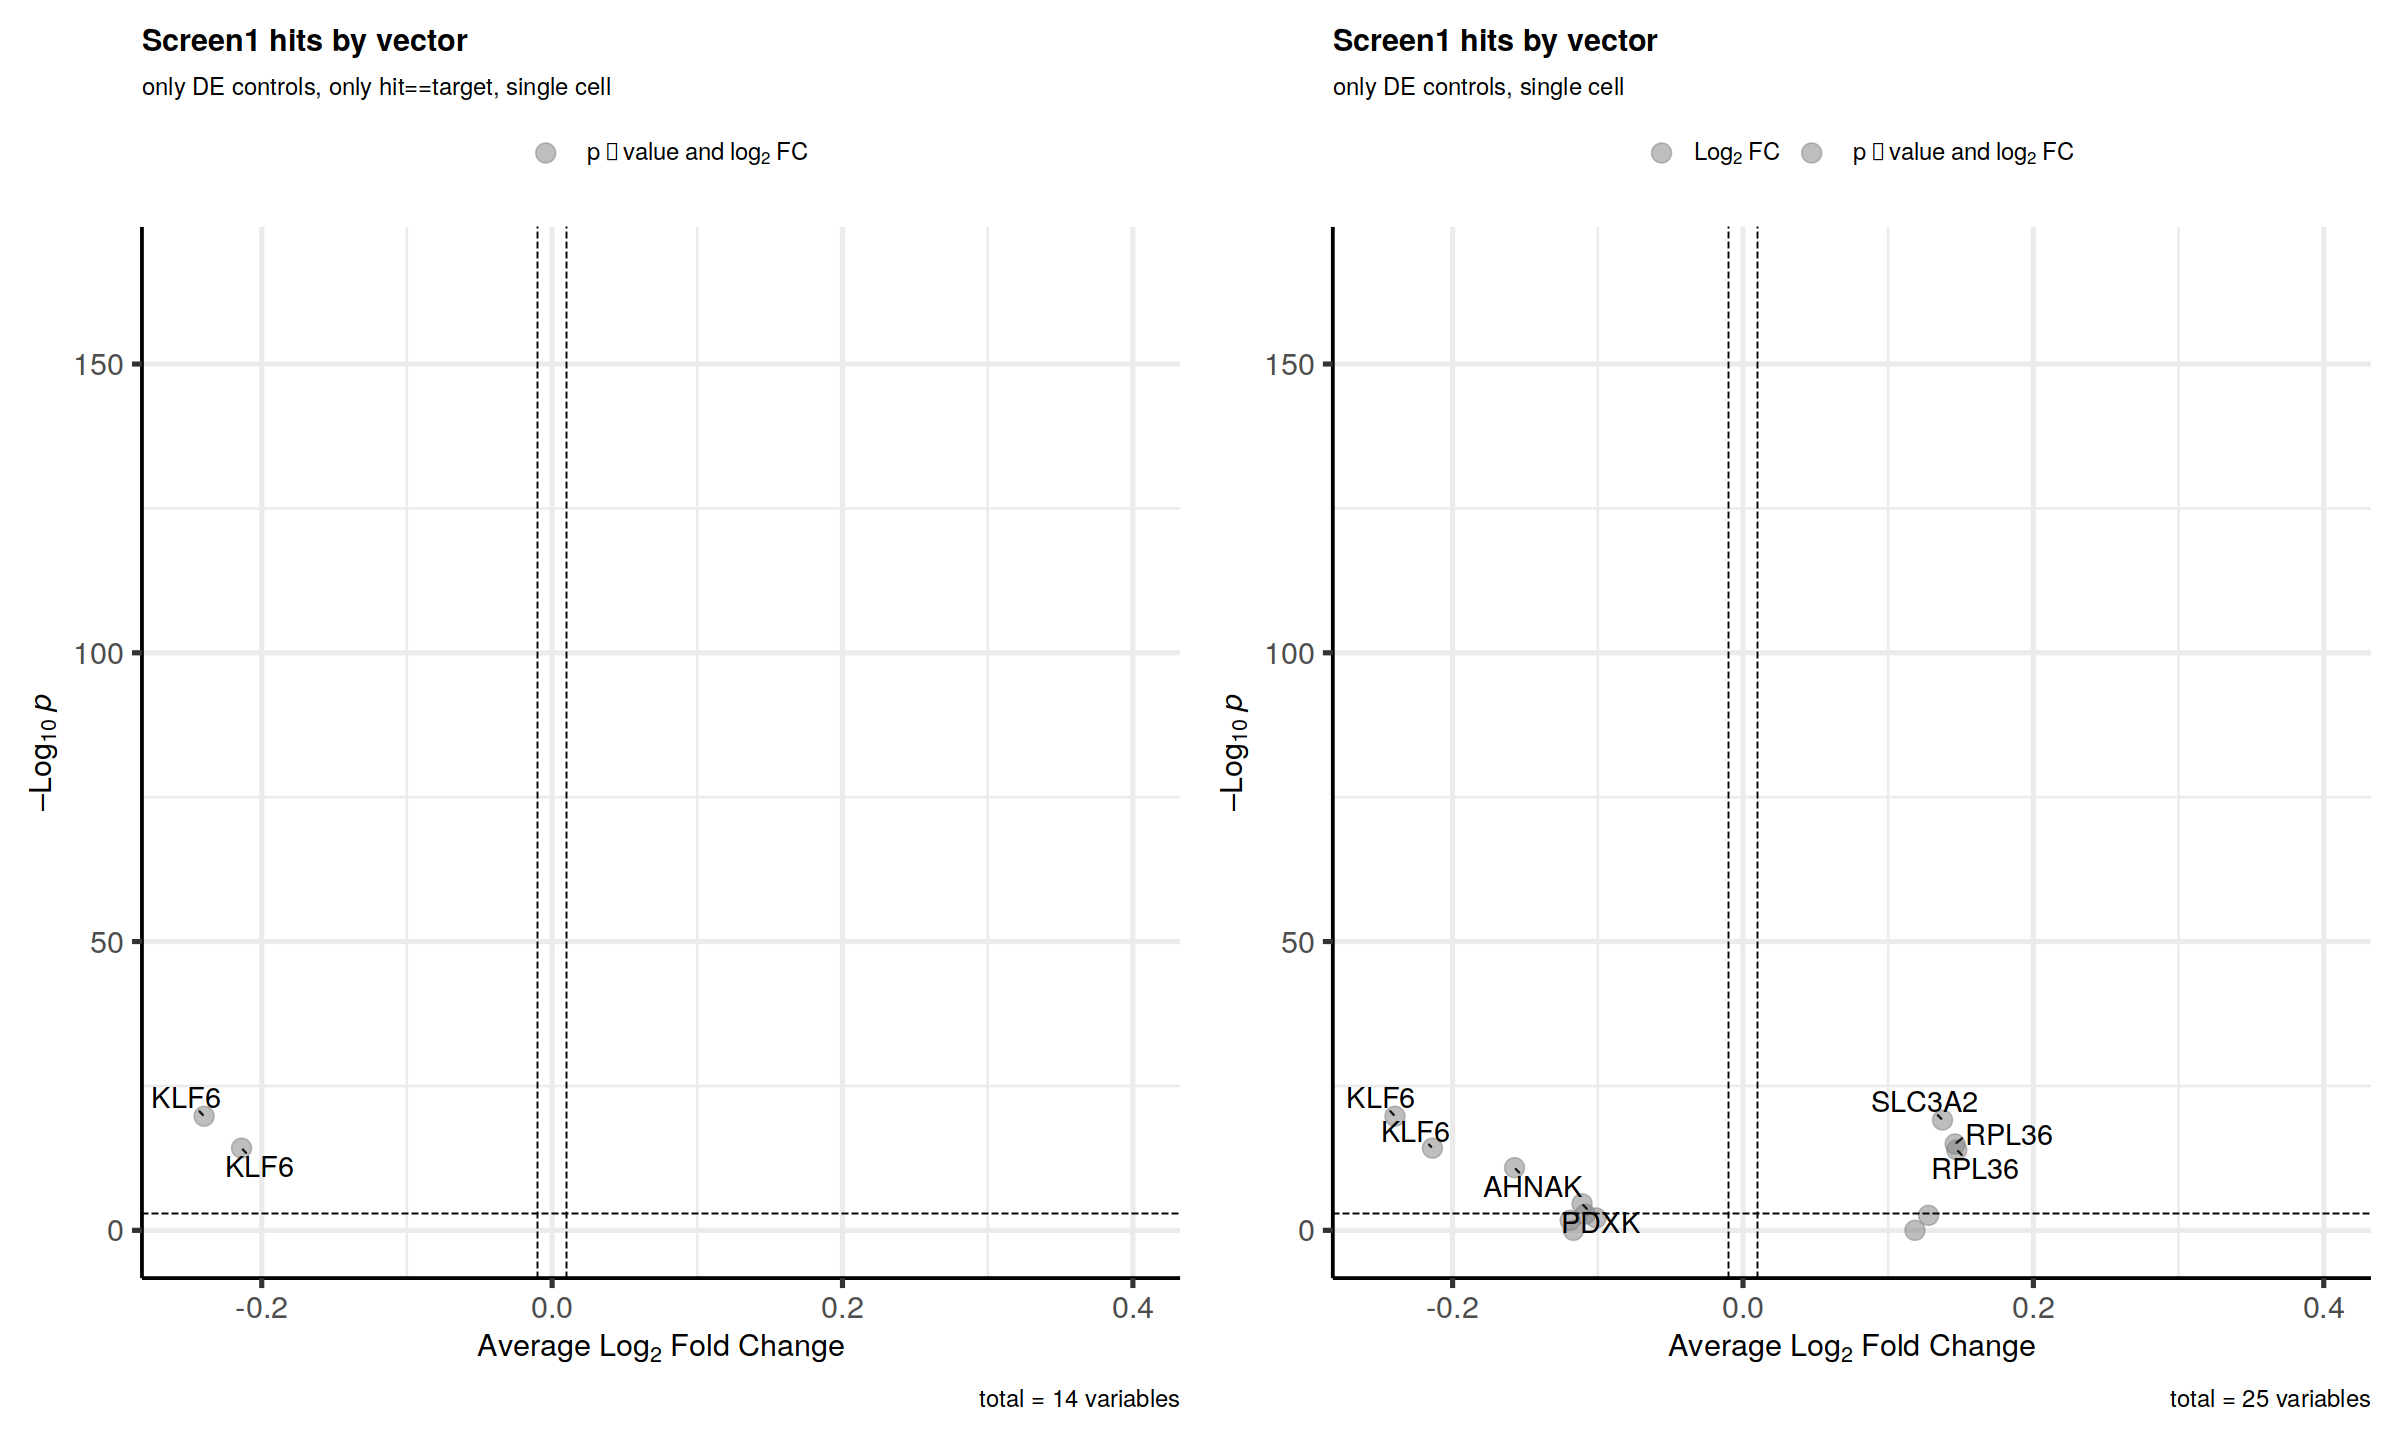

In [89]:
de_filter <- (df_neighbor_de$subclass == "de_control") &
    (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset <- df_neighbor_de[de_filter, ]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 <- EnhancedVolcano(df_neighbor_de_subset,
    lab = df_neighbor_de_subset$de_gene,
    x = "avg_log2FC",
    y = "p_val_adj",
    title = paste(prj_name, "hits by vector"),
    subtitle = "only DE controls, only hit==target, single cell",
    col = "gray",
    drawConnectors = TRUE,
    arrowheads = FALSE,
    pCutoff = 10e-4,
    FCcutoff = logfc_threshold,
    pointSize = 5.0,
    labSize = 6.0
) +
    xlim(-0.25, .4) +
    xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
    ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter <- (df_neighbor_de$subclass == "de_control")
df_neighbor_de_subset <- df_neighbor_de[de_filter, ]
p2 <- EnhancedVolcano(df_neighbor_de_subset,
    lab = df_neighbor_de_subset$de_gene,
    x = "avg_log2FC",
    y = "p_val_adj",
    title = paste(prj_name, "hits by vector"),
    subtitle = "only DE controls, single cell",
    col = "gray",
    drawConnectors = TRUE,
    arrowheads = FALSE,
    pCutoff = 10e-4,
    FCcutoff = logfc_threshold,
    pointSize = 5.0,
    labSize = 6.0
) +
    xlim(-0.25, .4) +
    xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
    ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2


### Plot just the CKD DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


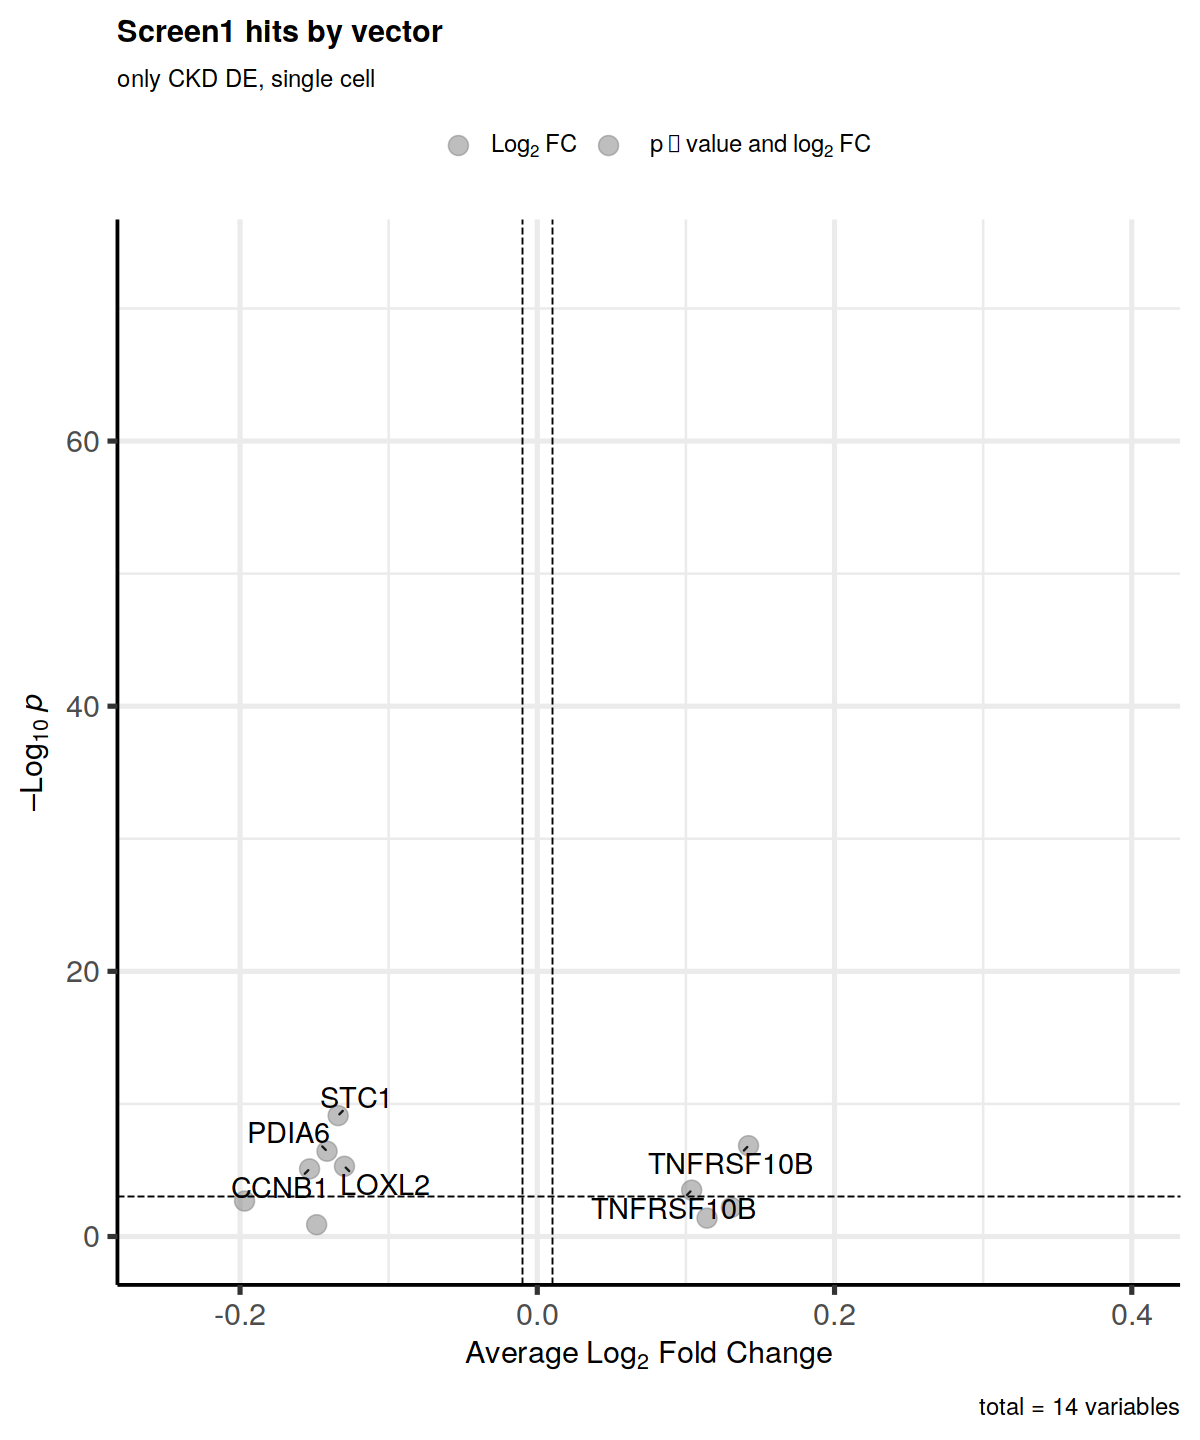

In [90]:
de_filter <- (df_neighbor_de$label == "CKD DE")
df_neighbor_de_subset <- df_neighbor_de[de_filter, ]

options(repr.plot.width = 10, repr.plot.height = 12)
p1 <- EnhancedVolcano(df_neighbor_de_subset,
    lab = df_neighbor_de_subset$de_gene,
    x = "avg_log2FC",
    y = "p_val_adj",
    title = paste(prj_name, "hits by vector"),
    subtitle = "only CKD DE, single cell",
    col = "gray",
    drawConnectors = TRUE,
    arrowheads = FALSE,
    pCutoff = 10e-4,
    FCcutoff = logfc_threshold,
    pointSize = 5.0,
    labSize = 6.0
) +
    xlim(-0.25, .4) +
    xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
    ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1


# Inspect further

In [91]:
df_neighbor_de %>%
    filter(avg_log2FC < 0) %>%
    arrange(adjusted_p_val) %>%
    head(25)


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.0e+00,-1.70,1.000,1.00,0.0e+00,FTH1,FTH1,de_control,FTH1-1,Control DE,0.0e+00
2,5.3e-267,-0.72,0.335,0.80,1.9e-262,NT5E,NT5E,tss,CD73-1,Control TSS,6.8e-264
3,1.5e-193,-0.37,0.167,0.59,5.6e-189,C15orf40,C15orf40,tss,C15orf40-1,Control TSS,2.0e-190
4,9.3e-165,-0.95,0.795,0.91,3.4e-160,LGALS3,LGALS3,de_control,LGALS3-1,Control DE,1.2e-161
5,6.3e-153,-0.34,1.000,1.00,2.3e-148,FTH1,FTH1,de_control,FTH1-2,Control DE,8.1e-150
6,4.3e-151,-0.63,0.463,0.78,1.6e-146,ANPEP,ANPEP,tss,CD13-1,Control TSS,5.5e-148
7,5.0e-136,-0.56,0.935,0.98,1.8e-131,TKT,TKT,de_control,TKT-2,Control DE,6.5e-133
8,3.3e-126,-0.87,0.809,0.91,1.2e-121,LGALS3,LGALS3,de_control,LGALS3-2,Control DE,4.3e-123
9,1.4e-99,-0.21,0.088,0.37,5.0e-95,CD55,CD55,tss,CD55-1,Control TSS,1.8e-96


In [92]:
df_neighbor_de %>%
    filter((subclass == "tss")) %>%
    filter(avg_log2FC < 0) %>%
    arrange(adjusted_p_val) %>%
    head(20)


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,5.3e-267,-0.72,0.335,0.80,1.9e-262,NT5E,NT5E,tss,CD73-1,Control TSS,6.8e-264
2,1.5e-193,-0.37,0.167,0.59,5.6e-189,C15orf40,C15orf40,tss,C15orf40-1,Control TSS,2.0e-190
3,4.3e-151,-0.63,0.463,0.78,1.6e-146,ANPEP,ANPEP,tss,CD13-1,Control TSS,5.5e-148
4,1.4e-99,-0.21,0.088,0.37,5.0e-95,CD55,CD55,tss,CD55-1,Control TSS,1.8e-96
5,6.0e-54,-0.25,0.476,0.68,2.2e-49,FUBP1,FUBP1,tss,FUBP1-1,Control TSS,7.7e-51
6,4.5e-36,-0.11,0.079,0.24,1.7e-31,MAFF,MAFF,tss,MAFF-1,Control TSS,5.8e-33
7,1.2e-13,-0.14,0.775,0.83,4.5e-09,IDH2,ANPEP,tss,CD13-1,Control TSS,1.6e-10
8,5.0e-08,-0.19,0.974,0.98,1.8e-03,LGALS1,MAFF,tss,MAFF-1,Control TSS,6.4e-05


In [93]:
df_neighbor_de %>%
    filter((subclass == "ckd_de")) %>%
    filter(adjusted_p_val < 1e-2) %>%
    arrange(adjusted_p_val) %>%
    head(30)


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2.4e-73,-0.33,0.52,0.67,8.7e-69,NDRG1,DE6,ckd_de,DE6-2,CKD DE,3.1e-70
2,2.5e-67,-0.38,0.49,0.67,9.1e-63,NDRG1,DE6,ckd_de,DE6-1,CKD DE,3.2e-64
3,1.7e-48,-0.33,0.94,0.97,6.3e-44,RBPMS,DE15,ckd_de,DE15-2,CKD DE,2.2e-45
4,3.4e-32,-0.31,0.95,0.97,1.2e-27,RBPMS,DE15,ckd_de,DE15-1,CKD DE,4.4e-29
5,2.1e-14,-0.13,0.32,0.39,7.6e-10,STC1,DE7,ckd_de,DE7-1,CKD DE,2.7e-11
6,3.9e-12,0.14,0.84,0.77,1.4e-07,TNFRSF10B,DE7,ckd_de,DE7-2,CKD DE,5.0e-09
7,1.0e-11,-0.14,0.96,0.97,3.7e-07,PDIA6,DE10,ckd_de,DE10-1,CKD DE,1.3e-08
8,1.4e-10,-0.13,0.47,0.55,5.1e-06,LOXL2,DE7,ckd_de,DE7-2,CKD DE,1.8e-07
9,2.2e-10,-0.15,0.23,0.26,8.0e-06,CCNB1,DE4,ckd_de,DE4-1,CKD DE,2.8e-07


In [94]:
df_neighbor_de %>% filter((subclass == "de_control") & (adjusted_p_val < 1e-10))


p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
0.0e+00,-1.70,1.00,1.00,0.0e+00,FTH1,FTH1,de_control,FTH1-1,Control DE,0.0e+00
6.3e-153,-0.34,1.00,1.00,2.3e-148,FTH1,FTH1,de_control,FTH1-2,Control DE,8.1e-150
2.2e-24,0.14,0.84,0.78,8.0e-20,SLC3A2,FTH1,de_control,FTH1-2,Control DE,2.8e-21
3.9e-16,-0.16,0.93,0.93,1.4e-11,AHNAK,FTH1,de_control,FTH1-2,Control DE,5.0e-13
2.8e-99,-0.37,0.65,0.81,1.0e-94,PLIN3,PLIN3,de_control,PLIN3-1,Control DE,3.6e-96
3.0e-20,0.15,1.00,1.00,1.1e-15,RPL36,PLIN3,de_control,PLIN3-1,Control DE,3.9e-17
1.3e-88,-0.36,0.65,0.80,4.8e-84,PLIN3,PLIN3,de_control,PLIN3-2,Control DE,1.7e-85
3.0e-19,0.15,1.00,1.00,1.1e-14,RPL36,PLIN3,de_control,PLIN3-2,Control DE,3.9e-16
4.0e-88,-0.51,0.95,0.98,1.5e-83,TKT,TKT,de_control,TKT-1,Control DE,5.2e-85


In [95]:
# select_significant_p  = df_neighbor_de$adjusted_p_val < 1
# df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "DE6", ], 20)
head(df_neighbor_de[df_neighbor_de$target == "DE15", ], 20)


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
38,2.5e-67,-0.38,0.49,0.67,9.1e-63,NDRG1,DE6,ckd_de,DE6-1,CKD DE,3.2e-64
39,2.4e-73,-0.33,0.52,0.67,8.7e-69,NDRG1,DE6,ckd_de,DE6-2,CKD DE,3.1e-70


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
45,3.4e-32,-0.31,0.95,0.97,1.2e-27,RBPMS,DE15,ckd_de,DE15-1,CKD DE,4.4e-29
46,1.7e-48,-0.33,0.94,0.97,6.3e-44,RBPMS,DE15,ckd_de,DE15-2,CKD DE,2.2e-45
